<a href="https://colab.research.google.com/github/ejlopezmor/Time-Series/blob/master/prueba_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program describe tendency of **Covid19** in Colombia. 


In [ ]:
# https://docs.anaconda.com/anaconda/navigator/tutorials/r-lang/
#################################################################
#################################################################
#####   COVID - 19 Program                                   ####
#####   Creation date: 20200605                              ####
#####   Edition date: 20200616                               ####
#####   Author: Javier López - ejlopezmor@gmail.com          ####
#################################################################
#################################################################

rm(list = ls())

#################################################################
#####                         Library                       #####  
#################################################################

#install.packages('dtwclust')
library(tidyr)
library(dplyr)
library(data.table)
library(stats)
library(RSocrata)
library(readxl)
library(readr)
library(leaflet)
library(leaflet.extras) 
library(ggplot2)
library(gridExtra)
library(gghighlight)
library(dtwclust)
library(tseries)

#################################################################
#####                         Folders                       #####  
#################################################################

### University John Hopkings
url_death <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_confi <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_recov <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

### Database of Colombia and Bogotá
url_col <- "https://www.datos.gov.co/resource/gt2j-8ykr.json"
url_bog <- "https://datosabiertos.bogota.gov.co/dataset/numero-de-casos-confirmados-por-el-laboratorio-de-covid-19-bogota-d-c/resource/b64ba3c4-9e41-41b8-b3fd-2da21d627558"

#################################################################
#####                       Load databases                  #####  
#################################################################

#### Descriptive and depuration database of Colombia ###

db.col <- read.socrata(url_col)
#db.bog <- read.socrata(url_bog)

db.col$f.noti <- as.Date(db.col$fecha_de_notificaci_n)
db.col$f.fis  <- as.Date(db.col$fis)
db.col$f.diag <- as.Date(db.col$fecha_diagnostico)
db.col$f.recu <- as.Date(db.col$fecha_recuperado)
db.col$f.repW <- as.Date(db.col$fecha_reporte_web)

db.death <- read_csv(url_death)
db.confi <- read_csv(url_confi)
db.recov <- read_csv(url_recov)

**Functions**

In [26]:
#################################################################
#####                         Functions                     #####  
#################################################################

covid.resume <- function(db.death = db.death, db.confi = db.confi, db.recov = db.recov,
                         var.pais = 'Colombia', var.tiempo = 'Tiempo', var.habit = 1e+05){
    
    #var.pais = 'Colombia'; var.tiempo = 'Tiempo'

db.death <- data.frame(db.death)
db.death.col <- db.death %>% 
    filter(Country.Region == var.pais)
    
db.confi <- data.frame(db.confi)
db.confi.col <- db.confi %>% 
    filter(Country.Region == var.pais)
    
db.recov <- data.frame(db.recov)
db.recov.col <- db.recov %>% 
    filter(Country.Region == var.pais)

ts.death.col <- ts(t(db.death.col[,-c(1:4)]), start = c(2020, 22), frequency=365)/var.habit
ts.confi.col <- ts(t(db.confi.col[,-c(1:4)]), start = c(2020, 22), frequency=365)/var.habit
ts.recov.col <- ts(t(db.recov.col[,-c(1:4)]), start = c(2020, 22), frequency=365)/var.habit
ts.activ.col <- (ts.confi.col - ts.recov.col - ts.death.col)

##### plot ######

time.data <- seq(as.Date("2020/1/22"), by = 'day', length.out = dim(ts.death.col)[1])
data.type <- data.frame(cbind(ts.death.col, ts.confi.col, ts.recov.col, ts.activ.col))
data.type <- cbind(time.data, data.type)
data.type <- data.type %>% filter(ts.confi.col != 0)
data.type$Num.dias <- 1:dim(data.type)[1]
names(data.type) <- c('Tiempo', 'Muertos', 'Confirmados', 'Recuperados', 'Activos', 'Dias.Transc')

data.type.1 <- melt(data.table(data.type), id.vars = c("Tiempo", "Dias.Transc"),
                    measure.vars = c('Muertos', 'Confirmados', 'Recuperados', 'Activos'))

if( var.tiempo == 'Dias.Transc' ){
    
    data.type.1 <- data.type.1 %>% filter(Dias.Transc <= 100)
    plot.type <- ggplot(data.type.1, aes(x = Dias.Transc,y = value, group = variable)) + 
    geom_line(aes(color = variable)) + ggtitle(paste('JHU COVID-19 en', var.pais))  +
    labs(y = 'Núm. Personas')

    
} else { 
    plot.type <- ggplot(data.type.1, aes(x = Tiempo,y = value, group = variable)) + 
    geom_line(aes(color = variable)) + ggtitle(paste('JHU COVID-19 en', var.pais)) +
    labs(y = 'Núm. Personas')
}

return(list(plot.covid = plot.type, table.covid = data.type, table.covid.1 = data.type.1)) 

}


HWplot <- function(ts_object,  n.ahead=4,  CI=.95,  error.ribbon='green', line.size=1){

    hw_object  <- HoltWinters(ts_object)   
    forecast   <- predict(hw_object,  n.ahead=n.ahead,  prediction.interval=T,  level=CI)
    for_values <- data.frame(time=round(time(forecast),  3),  value_forecast=as.data.frame(forecast)$fit,  dev=as.data.frame(forecast)$upr-as.data.frame(forecast)$fit)
    fitted_values <- data.frame(time=round(time(hw_object$fitted),  3),  value_fitted=as.data.frame(hw_object$fitted)$xhat)
    actual_values <- data.frame(time=round(time(hw_object$x),  3),  Actual=c(hw_object$x))    
    
    graphset <- merge(actual_values,  fitted_values,  by='time',  all=TRUE)
    graphset <- merge(graphset,  for_values,  all=TRUE,  by='time')
    graphset[is.na(graphset$dev),  ]$dev<-0
    graphset$Fitted <- c(rep(NA,  NROW(graphset)-(NROW(for_values) + NROW(fitted_values))),  fitted_values$value_fitted,  for_values$value_forecast)
    graphset <- data.table(graphset)
    
    graphset.melt <- melt(graphset[, c('time', 'Actual', 'Fitted')], id='time')
    p <- ggplot(graphset.melt,  aes(x=time,  y=value)) + 
    geom_ribbon(data=graphset, aes(x=time, y=Fitted, ymin=Fitted-dev,  ymax=Fitted + dev),  alpha=.2,  fill=error.ribbon) + 
    geom_line(aes(colour=variable), size=line.size) + 
    #geom_vline(x=max(actual_values$time),  lty=2) + 
    xlab('Time') + ylab('Value') + scale_colour_hue('')
    
    return(list(plot = p, prono = forecast))
}

**Acumulative Descriptive:**
This statistics show you confirm, recovery, actives, and deaths cases in Colombia.

In [ ]:
#################################################################
#####                         Analysis                      #####  
#################################################################

db.count.confi <- db.col %>%
#filter(codigo_divipola == '11001') %>%
group_by(f.repW) %>% 
tally() %>%
mutate(acum = cumsum(n))

db.count.confi$n    <- as.numeric(db.count.confi$n)
db.count.confi$acum <- as.numeric(db.count.confi$acum)

reporte.MS <- db.count.confi
names(reporte.MS) <- c('Tiempo', 'Confi.diarios', 'Confi.acum')

db.count.dead <- db.col %>%
filter(atenci_n %in% c('Fallecido')) %>%
group_by(f.repW) %>% 
tally() 
names(db.count.dead) <- c('Tiempo', 'Muertos.diario')

db.count.recup <- db.col %>%
filter(atenci_n %in% c('Recuperado')) %>%
group_by(f.repW) %>% 
tally()
names(db.count.recup) <- c('Tiempo', 'Recuperados.diario')

names(db.count.confi) <- c('Tiempo', 'Confirmados.diario', 'Confirmados')

tab.MS <- left_join(db.count.confi, db.count.recup)
tab.MS <- left_join(tab.MS, db.count.dead)

tab.MS <- tab.MS %>%
replace_na(list(Recuperados.diario = 0, Muertos.diario = 0))
tab.MS$Activos.diario <- tab.MS$Confirmados.diario - tab.MS$Recuperados.diario - tab.MS$Muertos.diario

tab.MS$Recuperados <- cumsum(tab.MS$Recuperados.diario)
tab.MS$Muertos     <- cumsum(tab.MS$Muertos.diario)
tab.MS$Activos     <- tab.MS$Confirmados - tab.MS$Recuperados - tab.MS$Muertos

tab.MS.plot <- melt(data.table(tab.MS), id.vars = c("Tiempo"),
                    measure.vars = c('Muertos', 'Confirmados', 'Recuperados', 'Activos'))

plot.tab.MS <- ggplot(tab.MS.plot, aes(x = Tiempo, y = value, group = variable)) + 
geom_line(aes(color = variable)) + ggtitle(paste('Min. Salud COVID-19')) + #+ theme(legend.position="bottom")  +
labs(y = 'Núm. Personas')

tab.MS.plot.muer <- tab.MS.plot %>% filter(variable == 'Muertos')
plot.tab.MS.muer <- ggplot(tab.MS.plot.muer, aes(x = Tiempo, y = value, group = variable)) + 
geom_line(aes(color = variable)) + ggtitle(paste('Min. Salud Muertos COVID-19')) + #+ theme(legend.position="bottom")  +
labs(y = 'Núm. Personas')

tab.plot.dual <- tab.MS.plot %>% filter(variable != 'Muertos')
names(tab.plot.dual) <- c('Tiempo', 'Casos', 'Num.Personas')
tab.plot.dual <- left_join(tab.plot.dual, tab.MS.plot.muer)
names(tab.plot.dual) <- c('Tiempo', 'Casos', 'Num.Personas', 'Casos.2', 'Num.Muertos')

plot.dual <- tab.plot.dual %>% 
ggplot() +
  geom_line(aes(x = Tiempo, y = Num.Personas, color = Casos, group = Casos)) +
  geom_col(aes(x = Tiempo, y = Num.Muertos*4, fill = 'Fallecidos')) +
  scale_y_continuous(sec.axis = sec_axis(~./13, name = "Fallecidos")) +
  scale_fill_manual(name = NULL, values = c("Fallecidos" = "grey")) + 
 # theme(legend.position="bottom") +
    theme(axis.line.y.right = element_line(color = "grey"), 
        axis.ticks.y.right = element_line(color = "grey"),
        axis.text.y.right = element_text(color = "grey"), 
        axis.title.y.right = element_text(color = "grey")
        ) +
ggtitle(paste('Información acumulada COVID-19'))

mytheme <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.5)),
    colhead = list(fg_params=list(cex = 0.6)),
    rowhead = list(fg_params=list(cex = 0.5)))

grid.arrange(tableGrob(tail(tab.MS[, c('Tiempo', 'Muertos', 'Confirmados', 'Recuperados',
                                       'Activos', 'Muertos.diario', 'Confirmados.diario', 
                                       'Recuperados.diario', 'Activos.diario')], 5), 
                       rows = NULL, theme = mytheme),
             plot.dual, #plot.tab.MS, plot.tab.MS.muer,
             ncol = 1)


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
label_key: Ciudad

label_key: Departamento

Joining, by = "Fecha"



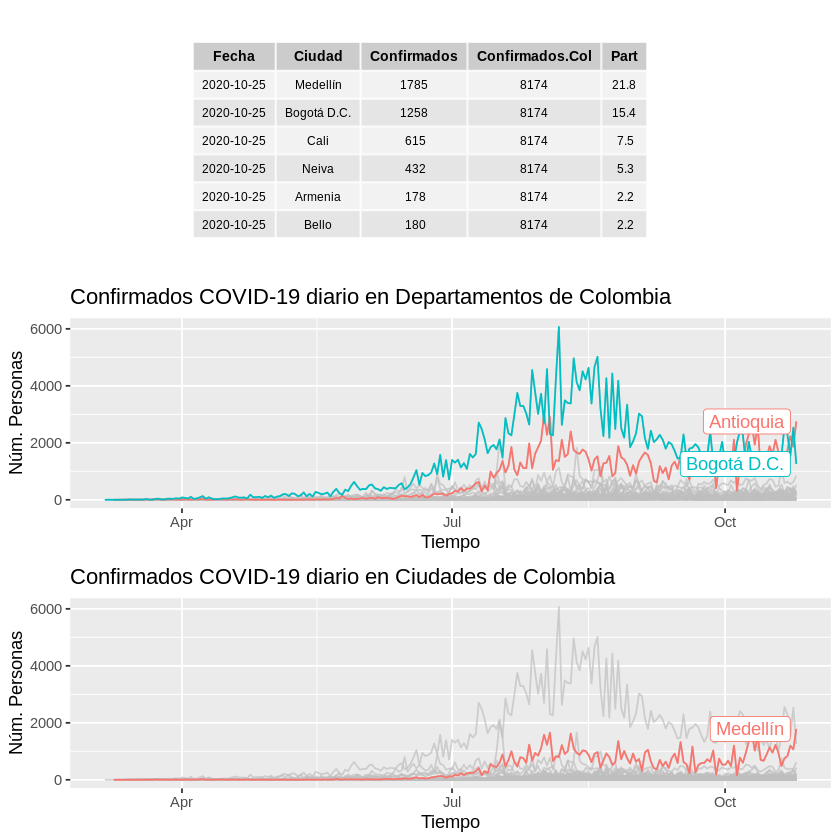

In [30]:
### City ###
db.count.city <- db.col %>%
#group_by(f.repW, c_digo_divipola, ciudad_de_ubicaci_n) %>%
group_by(f.repW, ciudad_de_ubicaci_n) %>%
tally() 
names(db.count.city) <- c('Fecha', 'Ciudad', 'Confirmados')

plot.min.city <- ggplot(db.count.city, aes(x = Fecha, y = Confirmados, group = Ciudad)) + 
geom_line(aes(color = Ciudad)) +
ggtitle(paste('Confirmados COVID-19 diario en Ciudades de Colombia'))  +
labs(y = 'Núm. Personas', x = 'Tiempo') +
gghighlight(Ciudad %in% c('Medellín'))#, 'Cartagena de Indias'))
#gghighlight(max(n) > 200, use_direct_label = FALSE) 
#gghighlight(max(n) > 200) 
 
### Departament ###
db.count.dep <- db.col %>%
#group_by(f.repW, c_digo_divipola, departamento) %>%
group_by(f.repW, departamento) %>%
tally() 
names(db.count.dep) <- c('Fecha', 'Departamento', 'Confirmados')

plot.min.dep <- ggplot(db.count.dep, aes(x = Fecha, y = Confirmados, group = Departamento)) + 
geom_line(aes(color = Departamento)) +
ggtitle(paste('Confirmados COVID-19 diario en Departamentos de Colombia'))  +
labs(y = 'Núm. Personas', x = 'Tiempo') +
#gghighlight(ciudad_de_ubicaci_n %in% c('Barranquilla', 'Cartagena de Indias'))
#gghighlight(max(n) > 200, use_direct_label = FALSE) 
gghighlight(max(Confirmados) > 2500) 


confi.pais <-  db.col %>%
group_by(f.repW) %>%
tally() 
names(confi.pais) <- c('Fecha', 'Confirmados.Col')
     
tab.part.city <- db.count.city %>% 
left_join(confi.pais) %>%
mutate(Part = round(Confirmados / Confirmados.Col * 100, 1)) %>%
filter(Fecha == max(db.count.city$Fecha)) %>%
arrange(-Part)

mytheme.2 <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.6)),
    colhead = list(fg_params=list(cex = 0.7)),
    rowhead = list(fg_params=list(cex = 0.5)))

grid.arrange(tableGrob(head(tab.part.city), rows = NULL, theme = mytheme.2),
             plot.min.dep, plot.min.city, ncol = 1)


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
label_key: Ciudad

label_key: Departamento

Joining, by = "Fecha"



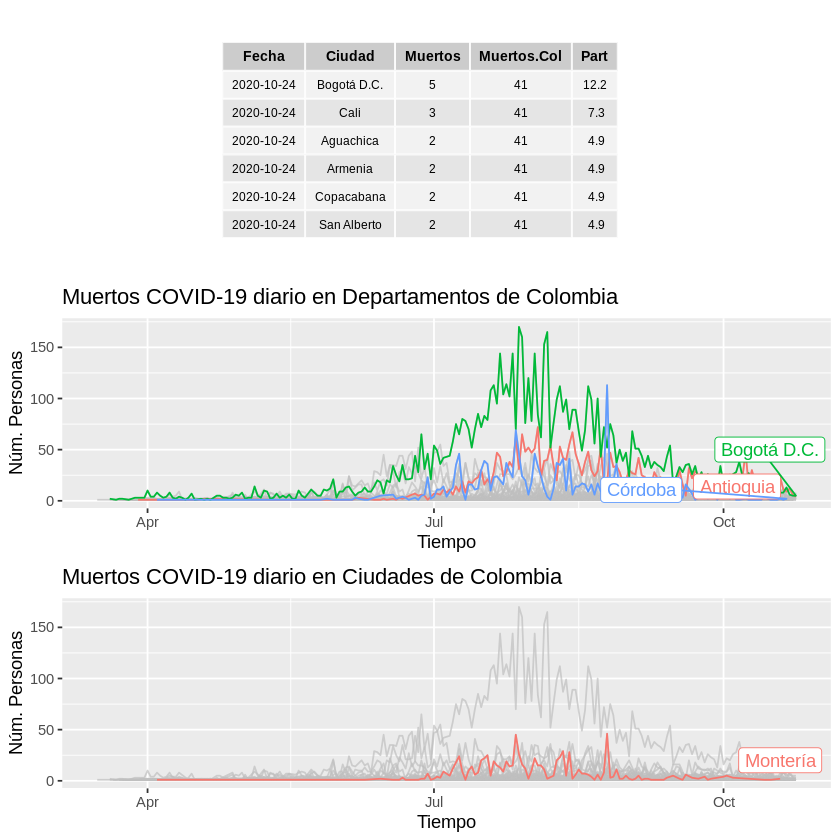

In [31]:
### Dead City ###
db.count.dead.city <- db.col %>%
filter(atenci_n %in% c('Fallecido')) %>%
group_by(f.repW, ciudad_de_ubicaci_n) %>% 
tally() 
names(db.count.dead.city) <- c('Fecha', 'Ciudad', 'Muertos')

plot.dead.city <- ggplot(db.count.dead.city, aes(x = Fecha, y = Muertos, group = Ciudad)) + 
geom_line(aes(color = Ciudad)) +
ggtitle(paste('Muertos COVID-19 diario en Ciudades de Colombia'))  +
labs(y = 'Núm. Personas', x = 'Tiempo') +
gghighlight(Ciudad %in% c('Montería'))
#gghighlight(max(n) > 200, use_direct_label = FALSE) 
#gghighlight(max(n) > 200) 
 
### Dead Departament ###
db.count.dead.dep <- db.col %>%
filter(atenci_n %in% c('Fallecido')) %>%
group_by(f.repW, departamento) %>%
tally() 
names(db.count.dead.dep) <- c('Fecha', 'Departamento', 'Muertos')

plot.dead.dep <- ggplot(db.count.dead.dep, aes(x = Fecha, y = Muertos, group = Departamento)) + 
geom_line(aes(color = Departamento)) +
ggtitle(paste('Muertos COVID-19 diario en Departamentos de Colombia'))  +
labs(y = 'Núm. Personas', x = 'Tiempo') +
#gghighlight(ciudad_de_ubicaci_n %in% c('Barranquilla', 'Cartagena de Indias'))
#gghighlight(max(n) > 200, use_direct_label = FALSE) 
gghighlight(max(Muertos) > 60) 

dead.country <-  db.col %>%
filter(atenci_n %in% c('Fallecido')) %>%
group_by(f.repW) %>%
tally() 
names(dead.country) <- c('Fecha', 'Muertos.Col')
     
tab.part.dead.city <- db.count.dead.city %>% 
left_join(dead.country) %>%
mutate(Part = round(Muertos / Muertos.Col * 100, 1)) %>%
filter(Fecha == max(db.count.dead.city$Fecha)) %>%
arrange(-Part)

mytheme.2 <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.6)),
    colhead = list(fg_params=list(cex = 0.7)),
    rowhead = list(fg_params=list(cex = 0.5)))

grid.arrange(tableGrob(head(tab.part.dead.city), rows = NULL, theme = mytheme.2),
             plot.dead.dep, plot.dead.city, ncol = 1)

